In [1]:
# Load and preprocess the dataset.
import idx2numpy
import tensorflow as tf
import numpy as np

# The dataset used is the EMNIST-letters.
# You can see info here: https://www.nist.gov/itl/products-and-services/emnist-dataset#:~:text=The%20EMNIST%20dataset%20is%20a,directly%20matches%20the%20MNIST%20dataset%20
# This dataset is available in two different file formats. Here I'm using the binary format.
# Download links for the dataset should be available at the bottom of the linked page above.
x_train = idx2numpy.convert_from_file('../datasets/emnist/emnist-letters-train-images-idx3-ubyte')
y_train = idx2numpy.convert_from_file('../datasets/emnist/emnist-letters-train-labels-idx1-ubyte')
x_test = idx2numpy.convert_from_file('../datasets/emnist/emnist-letters-test-images-idx3-ubyte')
y_test = idx2numpy.convert_from_file('../datasets/emnist/emnist-letters-test-labels-idx1-ubyte')

# Transpose the images because in the files they are stored in column-major order.
x_train = np.transpose(x_train, (0, 2, 1))
x_test = np.transpose(x_test, (0, 2, 1))

# Convert pixels to float and make them in the range [0, 1].
x_train = x_train / 255.0
x_test = x_test / 255.0

# Make letter classes start from 0.
y_train = y_train - 1
y_test = y_test - 1

# Convert class vectors to binary class matrices.
num_classes = 26  # 26 letters in english alphabet.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

img_rows = x_train.shape[1]
img_cols = x_train.shape[2]

print("Total examples:", x_train.shape[0] + x_test.shape[0])
print("Training examples:", x_train.shape[0])
print("Testing examples:", x_test.shape[0])
print("Image rows:", img_rows)
print("Image cols:", img_cols)

Total examples: 145600
Training examples: 124800
Testing examples: 20800
Image rows: 28
Image cols: 28


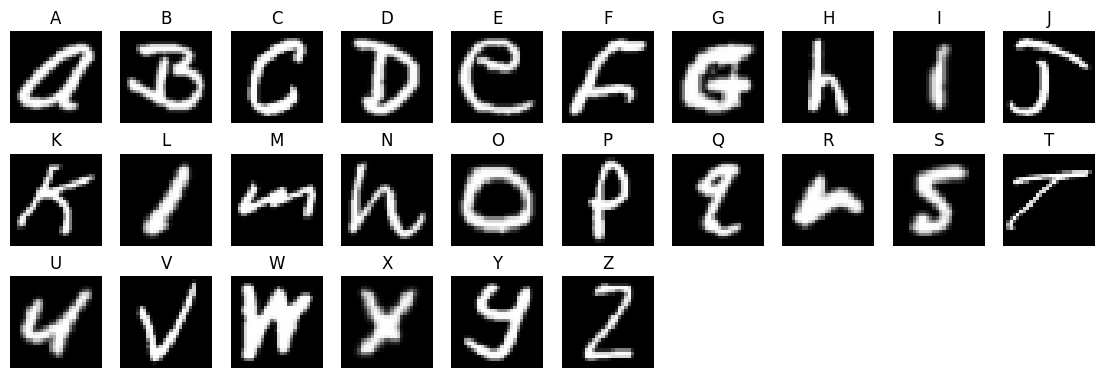

In [2]:
# Show some examples.
import matplotlib.pyplot as plt

def a_to_z(xs, ys):
    """Returns a list of images of letters A to Z."""
    images = list()
    for i in range(0, 26):
        index = np.where(ys == i)[0][0]
        images.append(xs[index])
    return images

def show_images(images):
    images = list(map(lambda img: (img * 255.0).astype(np.uint8), images))
    letters = list(map(chr, range(ord('A'), ord('Z') + 1)))
    
    plt.figure(figsize=(14, 4.5))
    for i in range(0, 26):
        plt.subplot(3, 10, i + 1)
        plt.axis('off')
        plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
        plt.title(letters[i])
    
show_images(a_to_z(x_train, np.argmax(y_train, axis=-1)))
# Note: The images from the dataset are white letter on black background. So the images below should also be displayed in this way.
# If you are using PyCharm IDE and the images below show as black letters on white background, it might be because you are using dark theme.
# Try using light theme to view them as the originals.

In [3]:
# Create model.
from tensorflow.keras import layers

model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(img_rows, img_cols, 1)),
        layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,186 (1.63 MB)

 Trainable params: 428,186 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Compile, train and save.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 256
epochs = 20
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model.save("../models/en-model.keras")

Epoch 1/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 59s 117ms/step - accuracy: 0.5768 - loss: 1.4271 - val_accuracy: 0.9052 - val_loss: 0.2972
Epoch 2/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 62s 126ms/step - accuracy: 0.8580 - loss: 0.4525 - val_accuracy: 0.9208 - val_loss: 0.2440
Epoch 3/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 63s 129ms/step - accuracy: 0.8850 - loss: 0.3597 - val_accuracy: 0.9277 - val_loss: 0.2213
Epoch 4/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 61s 125ms/step - accuracy: 0.9006 - loss: 0.3069 - val_accuracy: 0.9311 - val_loss: 0.2104
Epoch 5/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 59s 121ms/step - accuracy: 0.9108 - loss: 0.2792 - val_accuracy: 0.9361 - val_loss: 0.1966
Epoch 6/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 58s 118ms/step - accuracy: 0.9152 - loss: 0.2543 - val_accuracy: 0.9357 - val_loss: 0.1952
Epoch 7/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 60s 124ms/step - accuracy: 0.9217 - loss: 0.2387 - val_accuracy: 0.9372 - val_loss: 0.1895
Epoch 8/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 80s 163ms/step - accuracy: 0.9252 - loss: 0

In [9]:
# Run final evaluation on test and train datasets.
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)

Train accuracy: 0.969863772392273
Test accuracy: 0.9429807662963867
Train loss: 0.07688643783330917
Test loss: 0.19530251622200012


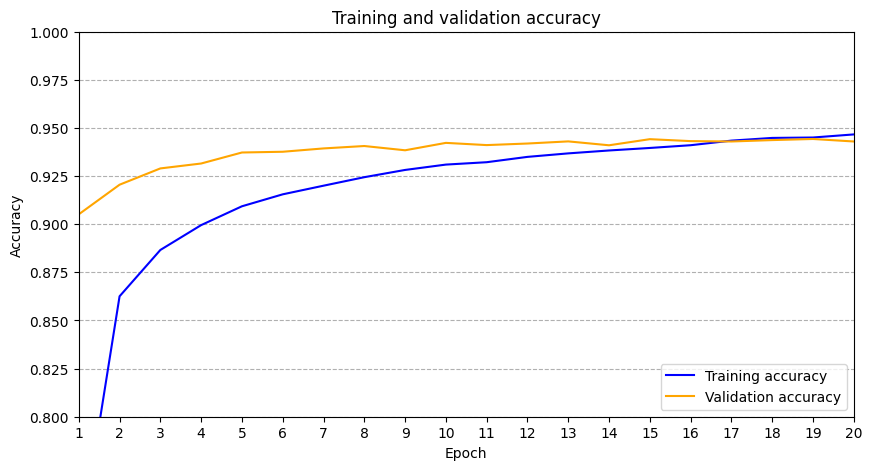

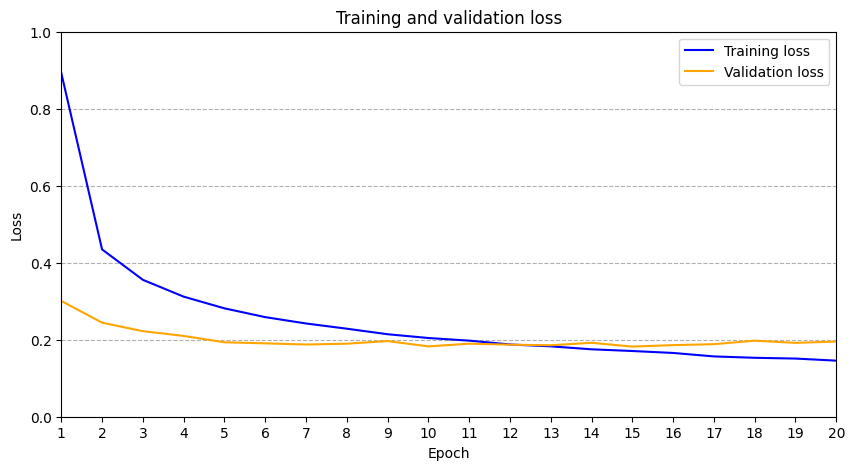

In [10]:
# Show training progress.

print('Train accuracy:', train_score[1])
print('Test accuracy:', test_score[1])
print('Train loss:', train_score[0])
print('Test loss:', test_score[0])

# Make accuracy plot.
epochs_range = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(10, 5))
plt.gca().set_ylim([0.8, 1.0])
plt.gca().set_xlim([epochs_range[0], epochs_range[-1]])
plt.xticks(epochs_range)
plt.grid(visible=True, axis='y', linestyle='--')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epochs_range, history.history['accuracy'], color='blue', label='Training accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], color='orange', label='Validation accuracy')
plt.legend(loc='lower right')
plt.show()

# Make loss plot.
plt.figure(figsize=(10, 5))
plt.gca().set_ylim([0.0, 1.0])
plt.gca().set_xlim([epochs_range[0], epochs_range[-1]])
plt.xticks(epochs_range)
plt.grid(visible=True, axis='y', linestyle='--')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs_range, history.history['loss'], color='blue', label='Training loss')
plt.plot(epochs_range, history.history['val_loss'], color='orange', label='Validation loss')
plt.legend(loc='upper right')
plt.show()